In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from orinoco import reproject_arr_to_match_profile, reproject_arr_to_new_crs
from pathlib import Path
import glob
from tqdm import tqdm

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

In [3]:
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')
products_for_map_dir_4326.mkdir(exist_ok=True)

In [4]:
with rasterio.open(data_path/f'{map_name}.tif') as ds:
    src_profile = ds.profile
    src_arr = ds.read()
src_arr_rgb = src_arr.transpose([1, 2, 0])[...,:3]


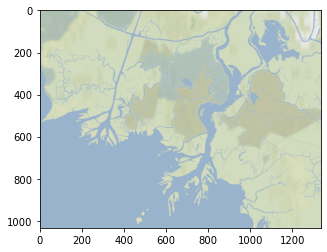

In [5]:
plt.imshow(src_arr_rgb)

In [6]:
if map_name == 'stamen_terrain_12':
    target_resolution = 0.0003
elif map_name == 'google_16':
    #  divide by 15 if really want the 2 meter raster
    #  Using the same resolution for both masks ensures that
    #  we have approximately the same indices for all viz
    target_resolution = 0.0003 #/ 15
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')


src_arr_4326, src_profile_4326 = reproject_arr_to_new_crs(src_arr, 
                                                          src_profile, 
                                                          'epsg:4326',
                                                          resampling='nearest',
                                                          target_resolution=target_resolution
                                                          )

In [7]:
src_arr_4326.shape

(4, 1029, 1528)

In [8]:
src_profile_4326['dtype'] = 'uint8'
with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif', 'w', **src_profile_4326) as ds:
    ds.write(src_arr_4326.astype(np.uint8))

In [9]:
src_arr_rgb_4326 = src_arr_4326.transpose([1, 2, 0])[...,:3].astype(int)

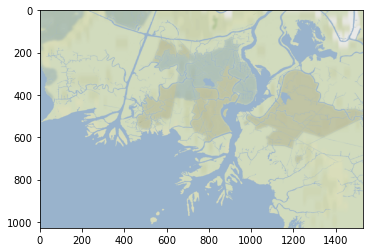

In [10]:
plt.imshow(src_arr_rgb_4326)

In [11]:
other_data = list(products_for_map_dir.glob('*.tif'))
other_data

[PosixPath('products/stamen_terrain_12/distance.tif'),
 PosixPath('products/stamen_terrain_12/skeletonize.tif'),
 PosixPath('products/stamen_terrain_12/ocean_mask.tif'),
 PosixPath('products/stamen_terrain_12/water_mask_original.tif'),
 PosixPath('products/stamen_terrain_12/segments_along_interface.tif'),
 PosixPath('products/stamen_terrain_12/channel_mask.tif'),
 PosixPath('products/stamen_terrain_12/segments.tif'),
 PosixPath('products/stamen_terrain_12/segments_rgb.tif'),
 PosixPath('products/stamen_terrain_12/water_mask.tif'),
 PosixPath('products/stamen_terrain_12/river_mask.tif'),
 PosixPath('products/stamen_terrain_12/segment_widths.tif')]

In [12]:
REFERENCE_PROFILE = src_profile_4326.copy()
REFERENCE_PROFILE['count'] = 1

def reproject_single_band(path):
    with rasterio.open(path) as ds:
        band = ds.read()
        profile = ds.profile
    r_copy = REFERENCE_PROFILE.copy()
    
    r_copy['count'] = profile['count']
    dtype = profile['dtype']
    r_copy['dtype'] = dtype
    
    band_r, _ = reproject_arr_to_match_profile(band, profile, r_copy, resampling='nearest')
    with rasterio.open(products_for_map_dir_4326/path.name, 'w', **r_copy) as ds:
        ds.write(band_r.astype(dtype))
    return products_for_map_dir_4326/path.name

In [13]:
list(map(reproject_single_band, tqdm(other_data)))

100%|██████████| 11/11 [00:01<00:00, 10.52it/s]


[PosixPath('products/stamen_terrain_12_4326/distance.tif'),
 PosixPath('products/stamen_terrain_12_4326/skeletonize.tif'),
 PosixPath('products/stamen_terrain_12_4326/ocean_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/water_mask_original.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments_along_interface.tif'),
 PosixPath('products/stamen_terrain_12_4326/channel_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments.tif'),
 PosixPath('products/stamen_terrain_12_4326/segments_rgb.tif'),
 PosixPath('products/stamen_terrain_12_4326/water_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/river_mask.tif'),
 PosixPath('products/stamen_terrain_12_4326/segment_widths.tif')]